### Library imports

In [17]:
# FathomNet 2025 @ CVPR-FGVC Competition
# Taxonomy-Aware Hierarchical Classifier

import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import torchvision.transforms as T
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')


### Configuration

In [18]:
# Path config
DATA_ROOT = "/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/"

class Config:
    # Paths
    TAXONOMY_PATH = os.path.join(DATA_ROOT, "taxonomy.csv")
    # TRAIN_ANNOTATIONS = os.path.join(DATA_ROOT, "augment_dataset", "combined_annotations.json")
    # TRAIN_IMAGE_DIR = os.path.join(DATA_ROOT, "augment_dataset", "images")
    COMBINED_ANNOTATIONS = os.path.join(DATA_ROOT, "augment_dataset", "combined_annotations.json")
    IMAGE_DIR = os.path.join(DATA_ROOT, "augment_dataset", "images") 
    TEST_ANNOTATIONS = os.path.join(DATA_ROOT, "test","annotations.csv")
    TEST_IMAGE_DIR = os.path.join(DATA_ROOT, "test", "rois")
    OUTPUT_DIR = os.path.join(DATA_ROOT, "outputs")
    SUBMISSION_PATH = os.path.join(DATA_ROOT, "submission.csv")
    
    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 8
    MAX_EPOCHS = 50
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 0.05
    LABEL_SMOOTHING = 0.1
    
    # Model parameters
    IMG_SIZE = 224
    BACKBONE = "convnext_base"
    
    # Taxonomic levels
    TAXONOMY_LEVELS = ["order", "family", "genus", "species"]
    
    # Inference parameters
    CONFIDENCE_THRESHOLD = 0.7
    
def check_path(path, is_dir=False):
    exists = os.path.exists(path)
    if not exists:
        return f"NOT FOUND: {path}"
    else:
        if is_dir:
            return f"Directory found: {path}"
        else:
            return f"File found: {path}"

print("Checking configured paths:")
print(check_path(Config.TAXONOMY_PATH))
# print(check_path(Config.TRAIN_ANNOTATIONS))
# print(check_path(Config.TRAIN_IMAGE_DIR, is_dir=True))
print(check_path(Config.COMBINED_ANNOTATIONS))
print(check_path(Config.IMAGE_DIR, is_dir=True))
print(check_path(Config.TEST_ANNOTATIONS))
print(check_path(Config.TEST_IMAGE_DIR, is_dir=True))
print(f"Output will be saved to: {os.path.abspath(Config.OUTPUT_DIR)}")

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

Checking configured paths:
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/taxonomy.csv
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/combined_annotations.json
Directory found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/test/annotations.csv
Directory found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/test/rois
Output will be saved to: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs


### Initialize vars

In [19]:
# Pipeline Control Panel
RUN_EXPLORATION = True       # Explore the dataset
RUN_TRAINING = True          # Train a new model
LOAD_PRETRAINED = True      # Instead of training, load a pretrained model
PRETRAINED_PATH = os.path.join(DATA_ROOT, "outputs", "best_model.ckpt")  # Path to pretrained model if LOAD_PRETRAINED=True
RUN_ANALYSIS = True          # Analyze model performance
GENERATE_SUBMISSION = True   # Generate submission file

# Initialize variables we'll need later
train_loader = None
val_loader = None
test_loader = None
taxonomy_df = None
encoders = None
class_counts = None
id_to_name = None
name_to_id = None
best_model_path = None

### Taxonomy Encoding

In [20]:
def load_and_encode_taxonomy():
    taxonomy_df = pd.read_csv(Config.TAXONOMY_PATH)
    encoders = {level: pd.factorize(taxonomy_df[level])[1] for level in Config.TAXONOMY_LEVELS}
    class_counts = taxonomy_df[Config.TAXONOMY_LEVELS].nunique().to_dict()
    id_to_name = dict(enumerate(taxonomy_df['species'].unique()))
    name_to_id = {v: k for k, v in id_to_name.items()}
    return taxonomy_df, encoders, class_counts, id_to_name, name_to_id


### Dataset classes

In [21]:
# Updated Dataset class for COCO-style JSON with bounding boxes
class FathomNetCOCODataset(Dataset):
    def __init__(self, coco_data, image_dir, taxonomy_df, encoders, image_ids, transform=None):
        self.coco_data = coco_data
        self.image_dir = image_dir
        self.taxonomy_df = taxonomy_df
        self.encoders = encoders
        self.image_ids = image_ids
        self.transform = transform

        # Indexing
        self.image_id_to_info = {img["id"]: img for img in coco_data["images"]}
        self.image_id_to_annotations = {}
        for ann in coco_data["annotations"]:
            self.image_id_to_annotations.setdefault(ann["image_id"], []).append(ann)
        self.cat_id_to_name = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

    def __len__(self):
        return len(self.image_ids)

    # def __getitem__(self, idx):
    #     image_id = self.image_ids[idx]
    #     image_info = self.image_id_to_info[image_id]
    #     annotations = self.image_id_to_annotations.get(image_id, [])

    #     image_path = os.path.join(self.image_dir, image_info["file_name"])
    #     try:
    #         image = Image.open(image_path).convert("RGB")
    #     except Exception as e:
    #         print(f"Error loading image {image_path}: {e}")
    #         image = Image.new("RGB", (image_info["width"], image_info["height"]))

    #     if self.transform:
    #         image = self.transform(image)

    #     boxes = []
    #     taxonomy_targets = []

    #     for ann in annotations:
    #         bbox = ann["bbox"]
    #         boxes.append(torch.tensor(bbox, dtype=torch.float32))

    #         # Get species name and encode taxonomy
    #         species = self.cat_id_to_name[ann["category_id"]]
    #         # row = self.taxonomy_df[self.taxonomy_df["species"] == species]
    #         # if row.empty:
    #         #     taxonomy = {level: 0 for level in Config.TAXONOMY_LEVELS}
    #         # else:
    #         #     row = row.iloc[0]
    #         #     taxonomy = {
    #         #         level: int(self.encoders[level].transform([row[level]])[0])
    #         #         for level in Config.TAXONOMY_LEVELS
    #         #         if level in row and level in self.encoders
    #         #     }
    #         row_df = self.taxonomy_df[self.taxonomy_df["species"] == species]

    #         if row_df.empty:
    #             taxonomy = {level: 0 for level in Config.TAXONOMY_LEVELS}
    #         else:
    #             row = row_df.iloc[0]  # Now a Series
    #             taxonomy = {}
    #             for level in Config.TAXONOMY_LEVELS:
    #                 try:
    #                     if level in row and pd.notna(row[level]) and level in self.encoders:
    #                         value = row[level]
    #                         encoded = self.encoders[level].transform([value])[0]
    #                         taxonomy[level] = int(encoded)
    #                     else:
    #                         taxonomy[level] = 0
    #                 except Exception as e:
    #                     taxonomy[level] = 0



    #         taxonomy_targets.append(taxonomy)

    #     return {
    #         "image": image,
    #         "boxes": boxes,
    #         "taxonomy": taxonomy_targets,
    #         "image_id": image_id
    #     }
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.image_id_to_info[image_id]
        annotations = self.image_id_to_annotations.get(image_id, [])

        image_path = os.path.join(self.image_dir, image_info["file_name"])
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image = Image.new("RGB", (image_info.get("width", 224), image_info.get("height", 224)))

        if self.transform:
            image = self.transform(image)

        # Use only the first annotation (if there are multiple)
        if not annotations:
            species = None
        else:
            species = self.cat_id_to_name[annotations[0]["category_id"]]

        # Encode taxonomy
        taxonomy = {}
        if species is None:
            taxonomy = {level: 0 for level in Config.TAXONOMY_LEVELS}
        else:
            row_df = self.taxonomy_df[self.taxonomy_df["species"] == species]
            if row_df.empty:
                taxonomy = {level: 0 for level in Config.TAXONOMY_LEVELS}
            else:
                row = row_df.iloc[0]
                for level in Config.TAXONOMY_LEVELS:
                    try:
                        if level in row and pd.notna(row[level]) and level in self.encoders:
                            value = row[level]
                            encoded = self.encoders[level].transform([value])[0]
                            taxonomy[level] = int(encoded)
                        else:
                            taxonomy[level] = 0
                    except Exception:
                        taxonomy[level] = 0

        return {
            "image": image,
            "taxonomy": taxonomy,
        }


class FathomNetTaxonomyDataset(Dataset):
    # Dataset for FathomNet with taxonomic information.    
    def __init__(self, image_paths, species_names, taxonomy_df, encoders, transform=None):
        self.image_paths = image_paths
        self.species_names = species_names
        self.taxonomy_df = taxonomy_df
        self.encoders = encoders
        self.transform = transform
        
        # Pre-compute taxonomic info for faster access
        self.taxonomic_info = []
        for species in species_names:
            row = self.taxonomy_df[self.taxonomy_df['species'] == species]
            if row.empty:
                print(f"Warning: Species '{species}' not found in taxonomy_df")
                # Use a default row
                self.taxonomic_info.append({level: 0 for level in Config.TAXONOMY_LEVELS})
            else:
                row = row.iloc[0]
                self.taxonomic_info.append({
                    level: int(row[f'{level}_id']) for level in Config.TAXONOMY_LEVELS 
                    if f'{level}_id' in row
                })

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Handle image loading errors gracefully
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image of the correct size
            img = torch.zeros(3, Config.IMG_SIZE, Config.IMG_SIZE)
        
        # Return image and taxonomic labels
        result = {'image': img}
        result.update(self.taxonomic_info[idx])
        
        return result

class FathomNetTestDataset(Dataset):
    # Dataset for FathomNet test set without labels.
    def __init__(self, image_paths, annotation_ids, transform=None):
        self.image_paths = image_paths
        self.annotation_ids = annotation_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        annotation_id = self.annotation_ids[idx]
        
        # Handle image loading errors gracefully
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image of the correct size
            img = torch.zeros(3, Config.IMG_SIZE, Config.IMG_SIZE)
        
        return {'image': img, 'annotation_id': annotation_id}

def collate_fn(batch):
    # Custom collate function to handle the taxonomy dataset.
    images = torch.stack([b['image'] for b in batch])
    
    # Collect labels for each taxonomic level
    # labels = {}
    # for level in Config.TAXONOMY_LEVELS:
    #     if level in batch[0]:
    #         labels[level] = torch.tensor([b[level] for b in batch])

    labels = {level: [] for level in Config.TAXONOMY_LEVELS}
    for b in batch:
        taxonomy = b["taxonomy"]
        for level in Config.TAXONOMY_LEVELS:
            labels[level].append(taxonomy[level])

    for level in labels:
        labels[level] = torch.tensor(labels[level], dtype=torch.long)
    
    return images, labels


def test_collate_fn(batch):
    # Custom collate function for test dataset.
    images = torch.stack([b['image'] for b in batch])
    annotation_ids = [b['annotation_id'] for b in batch]
    
    return images, annotation_ids

### Data transformations

In [22]:
def create_transforms():
    # Create augmentation pipelines for train and validation/test sets.
    # Training - strong augmentation to help with model generalization
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(Config.IMG_SIZE, scale=(0.5, 1.0)),  # Handle size variation
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation/Test - just resize and normalize
    val_transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

### Hierarchical Neural Network Model

In [23]:
class TaxonomyAwareClassifier(pl.LightningModule):
    # Classifier that leverages taxonomic hierarchy for marine species classification.
    def __init__(self, class_counts, lr=Config.LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()
        self.class_counts = class_counts
        
        # Load pretrained backbone
        weights = ConvNeXt_Base_Weights.DEFAULT
        backbone = convnext_base(weights=weights)
        self.feature_extractor = nn.Sequential(*(list(backbone.children())[:-2]))
        
        # Extract feature dimensions
        in_features = backbone.classifier[2].in_features
        
        # Shared feature network
        self.shared_features = nn.Sequential(
            nn.LayerNorm(in_features),  # Normalize before processing
            nn.Linear(in_features, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        
        # Create hierarchical network
        self._create_hierarchical_network(class_counts)
        
        # Loss function with label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)
        self.lr = lr
        
        # Track validation metrics
        self.val_step_outputs = []
        
    def _create_hierarchical_network(self, class_counts):
        # Create the hierarchical classification heads.
        # Order classification (top level)
        self.order_head = nn.Linear(1024, class_counts['order'])
        
        # Family classification (conditioned on order)
        self.order_to_family = nn.Linear(class_counts['order'], 512)
        self.family_features = nn.Linear(1024, 512)
        self.family_head = nn.Linear(1024, class_counts['family'])
        
        # Genus classification (conditioned on family)
        self.family_to_genus = nn.Linear(class_counts['family'], 512)
        self.genus_features = nn.Linear(1024, 512)
        self.genus_head = nn.Linear(1024, class_counts['genus'])
        
        # Species classification (conditioned on genus)
        self.genus_to_species = nn.Linear(class_counts['genus'], 512)
        self.species_features = nn.Linear(1024, 512)
        self.species_head = nn.Linear(1024, class_counts['species'])
    
    def forward(self, x):
        # Forward pass through the network.
        # Extract features from the backbone
        features = self.feature_extractor(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).squeeze(-1).squeeze(-1)
        
        # Apply shared feature processing
        shared = self.shared_features(features)
        
        # Order prediction (highest level)
        order_logits = self.order_head(shared)
        order_probs = torch.softmax(order_logits, dim=1)
        
        # Family prediction (conditioned on order)
        family_from_order = self.order_to_family(order_probs)
        family_from_features = self.family_features(shared)
        family_combined = torch.cat([family_from_order, family_from_features], dim=1)
        family_logits = self.family_head(family_combined)
        family_probs = torch.softmax(family_logits, dim=1)
        
        # Genus prediction (conditioned on family)
        genus_from_family = self.family_to_genus(family_probs)
        genus_from_features = self.genus_features(shared)
        genus_combined = torch.cat([genus_from_family, genus_from_features], dim=1)
        genus_logits = self.genus_head(genus_combined)
        genus_probs = torch.softmax(genus_logits, dim=1)
        
        # Species prediction (conditioned on genus)
        species_from_genus = self.genus_to_species(genus_probs)
        species_from_features = self.species_features(shared)
        species_combined = torch.cat([species_from_genus, species_from_features], dim=1)
        species_logits = self.species_head(species_combined)
        
        # Return logits for each taxonomic level
        return {
            'order': order_logits,
            'family': family_logits,
            'genus': genus_logits,
            'species': species_logits
        }
    
    def hierarchical_loss(self, outputs, targets):
        # Calculate hierarchical loss with weighting for different levels.        
        losses = {}
        total_loss = 0.0
        weights = {'order': 1.0, 'family': 1.5, 'genus': 2.0, 'species': 2.5}
        
        # Calculate losses for each available level
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs and level in targets:
                level_loss = self.criterion(outputs[level], targets[level])
                losses[level] = level_loss
                total_loss += weights[level] * level_loss
        # print("Levels with loss:", list(losses.keys()))
        # print("Weights used:", {l: weights.get(l, 0) for l in losses})
        
        # Normalize by total weight
        total_weight = sum(weights[l] for l in losses if l in weights)
        if total_weight == 0:
            total_weight = 1e-8  # or just return zero loss
        return total_loss / total_weight, losses

    
    def training_step(self, batch, batch_idx):
        # Unpack batch
        x, y = batch
        # x = batch["image"]
        # y = batch["taxonomy"]
        
        # Forward pass
        outputs = self(x)
        
        # Calculate loss
        loss, level_losses = self.hierarchical_loss(outputs, y)
        
        # Log metrics
        self.log("train_loss", loss, prog_bar=True)
        for level, level_loss in level_losses.items():
            self.log(f"train_{level}_loss", level_loss, prog_bar=False)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Unpack batch
        x, y = batch
        
        # Forward pass
        outputs = self(x)
        
        # Calculate loss
        loss, level_losses = self.hierarchical_loss(outputs, y)
        
        # Calculate accuracy for each level
        accuracy = {}
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs and level in y:
                preds = torch.argmax(outputs[level], dim=1)
                acc = (preds == y[level]).float().mean()
                accuracy[level] = acc
        
        # Log metrics
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        for level, level_loss in level_losses.items():
            self.log(f"val_{level}_loss", level_loss, prog_bar=False, sync_dist=True)
            
        for level, acc in accuracy.items():
            self.log(f"val_{level}_acc", acc, prog_bar=True, sync_dist=True)
        
        # Store outputs for epoch end processing
        self.val_step_outputs.append({
            'outputs': outputs,
            'targets': y
        })
        
        return loss
    
    def on_validation_epoch_end(self):
        # Skip if no validation steps were performed
        if not self.val_step_outputs:
            return
        
        # Collect all predictions and targets
        all_preds = {level: [] for level in Config.TAXONOMY_LEVELS}
        all_targets = {level: [] for level in Config.TAXONOMY_LEVELS}
        
        for output in self.val_step_outputs:
            for level in Config.TAXONOMY_LEVELS:
                if level in output['outputs'] and level in output['targets']:
                    pred = torch.argmax(output['outputs'][level], dim=1).cpu()
                    target = output['targets'][level].cpu()
                    all_preds[level].append(pred)
                    all_targets[level].append(target)
        
        # Concatenate predictions and targets
        for level in Config.TAXONOMY_LEVELS:
            if all_preds[level]:
                all_preds[level] = torch.cat(all_preds[level])
                all_targets[level] = torch.cat(all_targets[level])
        
        # Calculate overall accuracy for each level
        for level in Config.TAXONOMY_LEVELS:
            if len(all_preds[level]) > 0:
                acc = (all_preds[level] == all_targets[level]).float().mean()
                self.log(f"val_{level}_acc_epoch", acc, prog_bar=True)
        
        # Clear stored outputs
        self.val_step_outputs.clear()
    
    def predict_step(self, batch, batch_idx):
        # Generate predictions for test data
        # Handle both batched images and (images, _) tuples
        if isinstance(batch, tuple) and len(batch) == 2:
            images, annotation_ids = batch
        else:
            images = batch
            annotation_ids = None
        
        # Forward pass
        outputs = self(images)
        
        # Get probabilities and predictions for each level
        results = {}
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs:
                probs = torch.softmax(outputs[level], dim=1)
                preds = torch.argmax(probs, dim=1)
                conf = torch.gather(probs, 1, preds.unsqueeze(1)).squeeze(1)
                
                results[level] = {
                    'pred': preds.cpu(),
                    'conf': conf.cpu(),
                    'probs': probs.cpu()
                }
        
        if annotation_ids is not None:
            results['annotation_ids'] = annotation_ids
            
        return results
    
    def configure_optimizers(self):
        # Configure optimizers with different learning rates for backbone vs heads
        # Group parameters by part of the model
        backbone_params = self.feature_extractor.parameters()
        classifier_params = [p for n, p in self.named_parameters() 
                            if "feature_extractor" not in n]
        
        # Create parameter groups with different learning rates
        param_groups = [
            {'params': backbone_params, 'lr': self.lr / 10},  # Lower LR for backbone
            {'params': classifier_params, 'lr': self.lr}
        ]
        
        # Create optimizer
        optimizer = torch.optim.AdamW(param_groups, weight_decay=Config.WEIGHT_DECAY)
        
        # Create learning rate scheduler
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=5, T_mult=2, eta_min=1e-6
            ),
            "interval": "epoch",
            "frequency": 1,
        }
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

### Data preparation

In [24]:
def prepare_data():
    print("Preparing datasets...")

    # Load COCO annotations
    with open(Config.COMBINED_ANNOTATIONS, "r") as f:
        coco_data = json.load(f)

    # Map image_id to its most frequent category (stratification proxy)
    image_id_to_cat = {}
    for ann in coco_data["annotations"]:
        image_id_to_cat.setdefault(ann["image_id"], []).append(ann["category_id"])

    # Use the most common category_id per image for stratified splitting
    image_ids = list(image_id_to_cat.keys())
    dominant_labels = [Counter(image_id_to_cat[i]).most_common(1)[0][0] for i in image_ids]

    # Split 85% train / 15% val
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    train_idx, val_idx = next(sss.split(image_ids, dominant_labels))
    train_ids = [image_ids[i] for i in train_idx]
    val_ids = [image_ids[i] for i in val_idx]

    # Transforms
    train_transform, val_transform = create_transforms()

    # Taxonomy and encoders
    taxonomy_df, encoders, class_counts, id_to_name, name_to_id = load_and_encode_taxonomy()

    # Datasets
    train_dataset = FathomNetCOCODataset(
        coco_data=coco_data,
        image_dir=Config.IMAGE_DIR,
        taxonomy_df=taxonomy_df,
        encoders=encoders,
        image_ids=train_ids,
        transform=train_transform
    )

    val_dataset = FathomNetCOCODataset(
        coco_data=coco_data,
        image_dir=Config.IMAGE_DIR,
        taxonomy_df=taxonomy_df,
        encoders=encoders,
        image_ids=val_ids,
        transform=val_transform
    )

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        collate_fn=collate_fn,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        collate_fn=collate_fn,
        pin_memory=True
    )

    print(f"Train: {len(train_dataset)} images")
    print(f"Val: {len(val_dataset)} images")

    return train_loader, val_loader, taxonomy_df, encoders, class_counts, id_to_name, name_to_id

### Training function

In [25]:
def train_model(train_loader, val_loader, class_counts):
    # Train the model using PyTorch Lightning.    
    print("Starting model training...")
    
    # Create model
    model = TaxonomyAwareClassifier(class_counts=class_counts)
    
    # Create callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=Config.OUTPUT_DIR,
        filename='fathomnet-{epoch:02d}-{val_loss:.4f}',
        save_top_k=3,
        monitor='val_loss',
        mode='min'
    )
    
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    # Create trainer
    trainer = pl.Trainer(
        max_epochs=Config.MAX_EPOCHS,
        accelerator="gpu",
        devices=1,
        precision=16,  # Mixed precision for faster training
        callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
        log_every_n_steps=50,
        default_root_dir=Config.OUTPUT_DIR,
        enable_progress_bar=True,
        profiler="simple",
        deterministic=True,
        enable_model_summary=True,
        enable_checkpointing=True,
        logger=True,
    )
    
    # Train model
    trainer.fit(model, train_loader, val_loader)
    
    # Return best model path
    return checkpoint_callback.best_model_path

### Test Data Preparation

In [26]:
def prepare_test_data(taxonomy_df):
    # Prepare test dataset and dataloader.
        
    print("Preparing test dataset...")
    
    # Load test annotations
    test_annotations = pd.read_csv(Config.TEST_ANNOTATIONS)
    test_image_paths = [os.path.join(Config.TEST_IMAGE_DIR, p) for p in test_annotations['path']]
    
    # Use row indices as IDs since there's no annotation_id column
    test_annotation_ids = list(range(len(test_annotations)))
    
    print(f"Using row indices (0 to {len(test_annotations)-1}) as annotation IDs")
    
    # Create transforms
    _, test_transform = create_transforms()
    
    # Create test dataset
    test_dataset = FathomNetTestDataset(
        test_image_paths, test_annotation_ids, transform=test_transform
    )
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=Config.NUM_WORKERS, 
        collate_fn=test_collate_fn
    )
    
    print(f"Test dataset: {len(test_dataset)} images")
    
    return test_loader

### Inference and submission

In [27]:
import pandas as pd

taxonomy_df = taxonomy_df = pd.read_csv(Config.TAXONOMY_PATH)
taxonomy_df = taxonomy_df.dropna(subset=["species"])  # filter nulls


In [28]:
from collections import defaultdict

# Map from genus/family/order to most common species
genus_to_species = defaultdict(str)
family_to_species = defaultdict(str)
order_to_species = defaultdict(str)

# Group by and use first listed species (or most frequent, if you want more logic)
for level, mapping in [("genus", genus_to_species),
                       ("family", family_to_species),
                       ("order", order_to_species)]:
    
    grouped = taxonomy_df.groupby(level)["species"].agg(lambda x: x.value_counts().idxmax())
    
    for k, v in grouped.items():
        mapping[k] = v

print("Fallback mappings created.")


Fallback mappings created.


In [29]:
def get_taxonomic_prediction(outputs, id_to_name, confidence_threshold, taxonomy_df):
    # Build fallback maps
    from collections import defaultdict

    genus_map = taxonomy_df.groupby("genus")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    family_map = taxonomy_df.groupby("family")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    order_map = taxonomy_df.groupby("order")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    
    predictions = {}
    confidences = {}
    
    for level in Config.TAXONOMY_LEVELS:
        preds = outputs[level]["pred"]
        confs = outputs[level]["conf"]
        predictions[level] = preds.tolist() if isinstance(preds, torch.Tensor) else preds
        confidences[level] = confs.tolist() if isinstance(confs, torch.Tensor) else confs

    id_to_name = {level: {int(k): str(v) for k, v in id_to_name[level].items()} for level in Config.TAXONOMY_LEVELS}
    
    best_names = []

    for i in range(len(predictions["order"])):
        # Try species directly
        species_id = predictions["species"][i]
        species_conf = confidences["species"][i]
        species_name = id_to_name["species"].get(species_id)

        if species_name and species_conf >= confidence_threshold:
            best_names.append(species_name)
            continue

        # Try genus → species
        genus_id = predictions["genus"][i]
        genus_name = id_to_name["genus"].get(genus_id)
        fallback_species = genus_map.get(genus_name)

        if fallback_species:
            best_names.append(fallback_species)
            continue

        # Try family → species
        family_id = predictions["family"][i]
        family_name = id_to_name["family"].get(family_id)
        fallback_species = family_map.get(family_name)

        if fallback_species:
            best_names.append(fallback_species)
            continue

        # Try order → species
        order_id = predictions["order"][i]
        order_name = id_to_name["order"].get(order_id)
        fallback_species = order_map.get(order_name)

        if fallback_species:
            best_names.append(fallback_species)
            continue

        # Final fallback: unknown
        best_names.append("fallback_species_unknown")

    return best_names


def generate_submission(model_path, test_loader, class_counts, id_to_name, taxonomy_df, taxonomic_mapping=None):
    # Generate submission file for the competition.# 
    print("Generating submission file...")
    
    # Load the best model
    model = TaxonomyAwareClassifier.load_from_checkpoint(
        model_path, class_counts=class_counts
    )
    model.eval()
    
    # Use GPU if available, otherwise CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running inference on: {device}")
    model.to(device)
    
    # Process test data manually
    all_annotation_ids = []
    all_predictions = {level: [] for level in Config.TAXONOMY_LEVELS}
    all_confidences = {level: [] for level in Config.TAXONOMY_LEVELS}
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Processing test data"):
            images, annotation_ids = batch
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Process outputs
            all_annotation_ids.extend(annotation_ids)
            
            for level in Config.TAXONOMY_LEVELS:
                if level in outputs:
                    # Convert logits to probabilities
                    probs = torch.softmax(outputs[level], dim=1)
                    preds = torch.argmax(probs, dim=1)
                    conf = torch.gather(probs, 1, preds.unsqueeze(1)).squeeze(1)
                    
                    all_predictions[level].extend(preds.cpu().numpy())
                    all_confidences[level].extend(conf.cpu().numpy())
    
    # Get final taxonomic predictions
    best_names = get_taxonomic_prediction(
        {'order': {'pred': all_predictions['order'], 'conf': all_confidences['order']},
         'family': {'pred': all_predictions['family'], 'conf': all_confidences['family']},
         'genus': {'pred': all_predictions['genus'], 'conf': all_confidences['genus']},
         'species': {'pred': all_predictions['species'], 'conf': all_confidences['species']}},
        id_to_name,
        confidence_threshold=Config.CONFIDENCE_THRESHOLD,
        taxonomy_df=taxonomy_df
    )
    
    # Map to valid submission taxa if needed
    if taxonomic_mapping is not None:
        best_names = [taxonomic_mapping.get(name, name) for name in best_names]
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'annotation_id': [id + 1 for id in all_annotation_ids],
        'concept_name': best_names
    })
    
    # Save submission file
    submission_df.to_csv(Config.SUBMISSION_PATH, index=False)
    print(f"Submission saved to {Config.SUBMISSION_PATH}")
    
    # Display submission distribution
    print("\nPrediction distribution:")
    value_counts = submission_df['concept_name'].value_counts().head(10)
    for name, count in value_counts.items():
        print(f"  {name}: {count} ({count/len(submission_df)*100:.1f}%)")
    
    return submission_df

### Exploratory Data Analysis

In [30]:
def explore_dataset():
    print("Loading combined COCO annotations...")
    
    # Load JSON
    with open(Config.COMBINED_ANNOTATIONS, "r") as f:
        data = json.load(f)

    images = data["images"]
    annotations = data["annotations"]
    categories = {cat["id"]: cat["name"] for cat in data["categories"]}

    print(f"Total images: {len(images)}")
    print(f"Total annotations: {len(annotations)}")
    print(f"Unique categories: {len(categories)}")

    # Category distribution
    category_counts = Counter([ann["category_id"] for ann in annotations])
    sorted_cats = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    top20 = sorted_cats[:20]
    top20_names = [categories[cid] for cid, _ in top20]
    top20_counts = [count for _, count in top20]

    # Plot top categories
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top20_counts, y=top20_names)
    plt.title("Top 20 Categories by Annotation Count")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    # Sample image display
    print("\nShowing example images...")
    image_dir = Config.IMAGE_DIR
    sample_imgs = np.random.choice(images, size=6, replace=False)

    plt.figure(figsize=(15, 10))
    for i, img_info in enumerate(sample_imgs):
        img_path = os.path.join(image_dir, img_info["file_name"])
        try:
            img = Image.open(img_path).convert("RGB")
            plt.subplot(2, 3, i + 1)
            plt.imshow(img)
            plt.title(f"{img_info['file_name']} ({img_info['width']}x{img_info['height']})")
            plt.axis("off")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    plt.tight_layout()
    plt.show()

    # Image size analysis
    print("\nAnalyzing image dimensions...")
    # widths = [img["width"] for img in images]
    # heights = [img["height"] for img in images]
    widths = []
    heights = []

    for img in images:
        try:
            if img.get("width") is not None and img.get("height") is not None:
                widths.append(img["width"])
                heights.append(img["height"])
        except Exception as e:
            print(f"Skipping image entry due to error: {e}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title("Width Distribution")
    plt.xlabel("Width (pixels)")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title("Height Distribution")
    plt.xlabel("Height (pixels)")

    plt.tight_layout()
    plt.show()

    print(f"Median width: {np.median(widths)}, Median height: {np.median(heights)}")
    
    bad_entries = [img for img in images if img.get("width") is None or img.get("height") is None]
    print(f"{len(bad_entries)} image(s) missing width or height")

    return annotations

### Run exploration and prepare data

RUN_EXPLORATION = True
Starting exploratory data analysis...
Loading combined COCO annotations...


Total images: 34352
Total annotations: 46962
Unique categories: 79


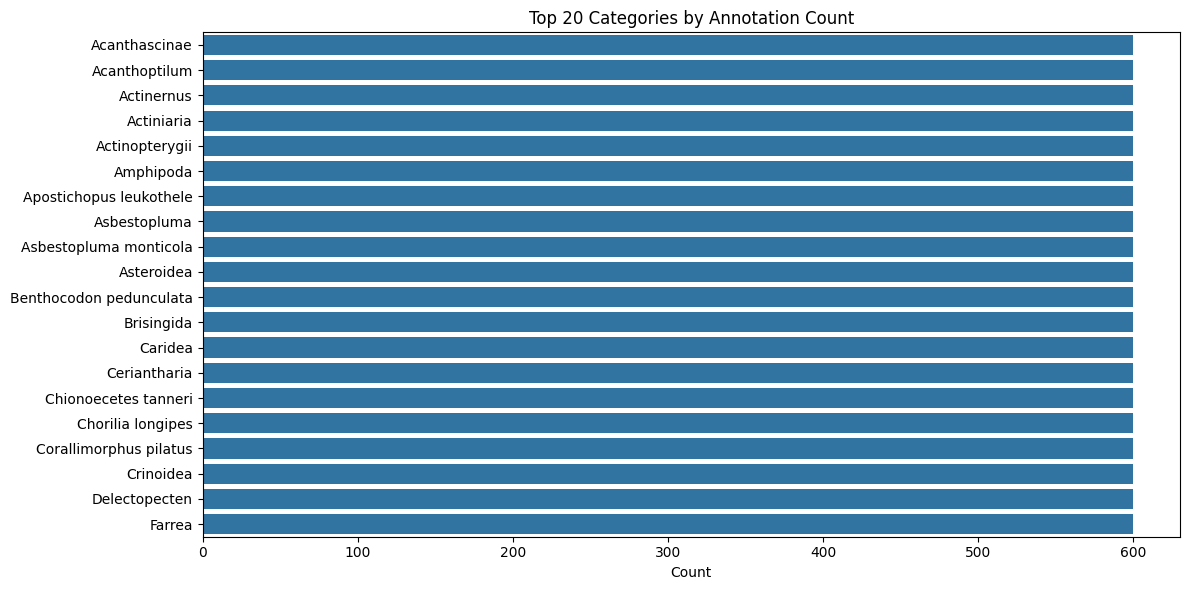


Showing example images...


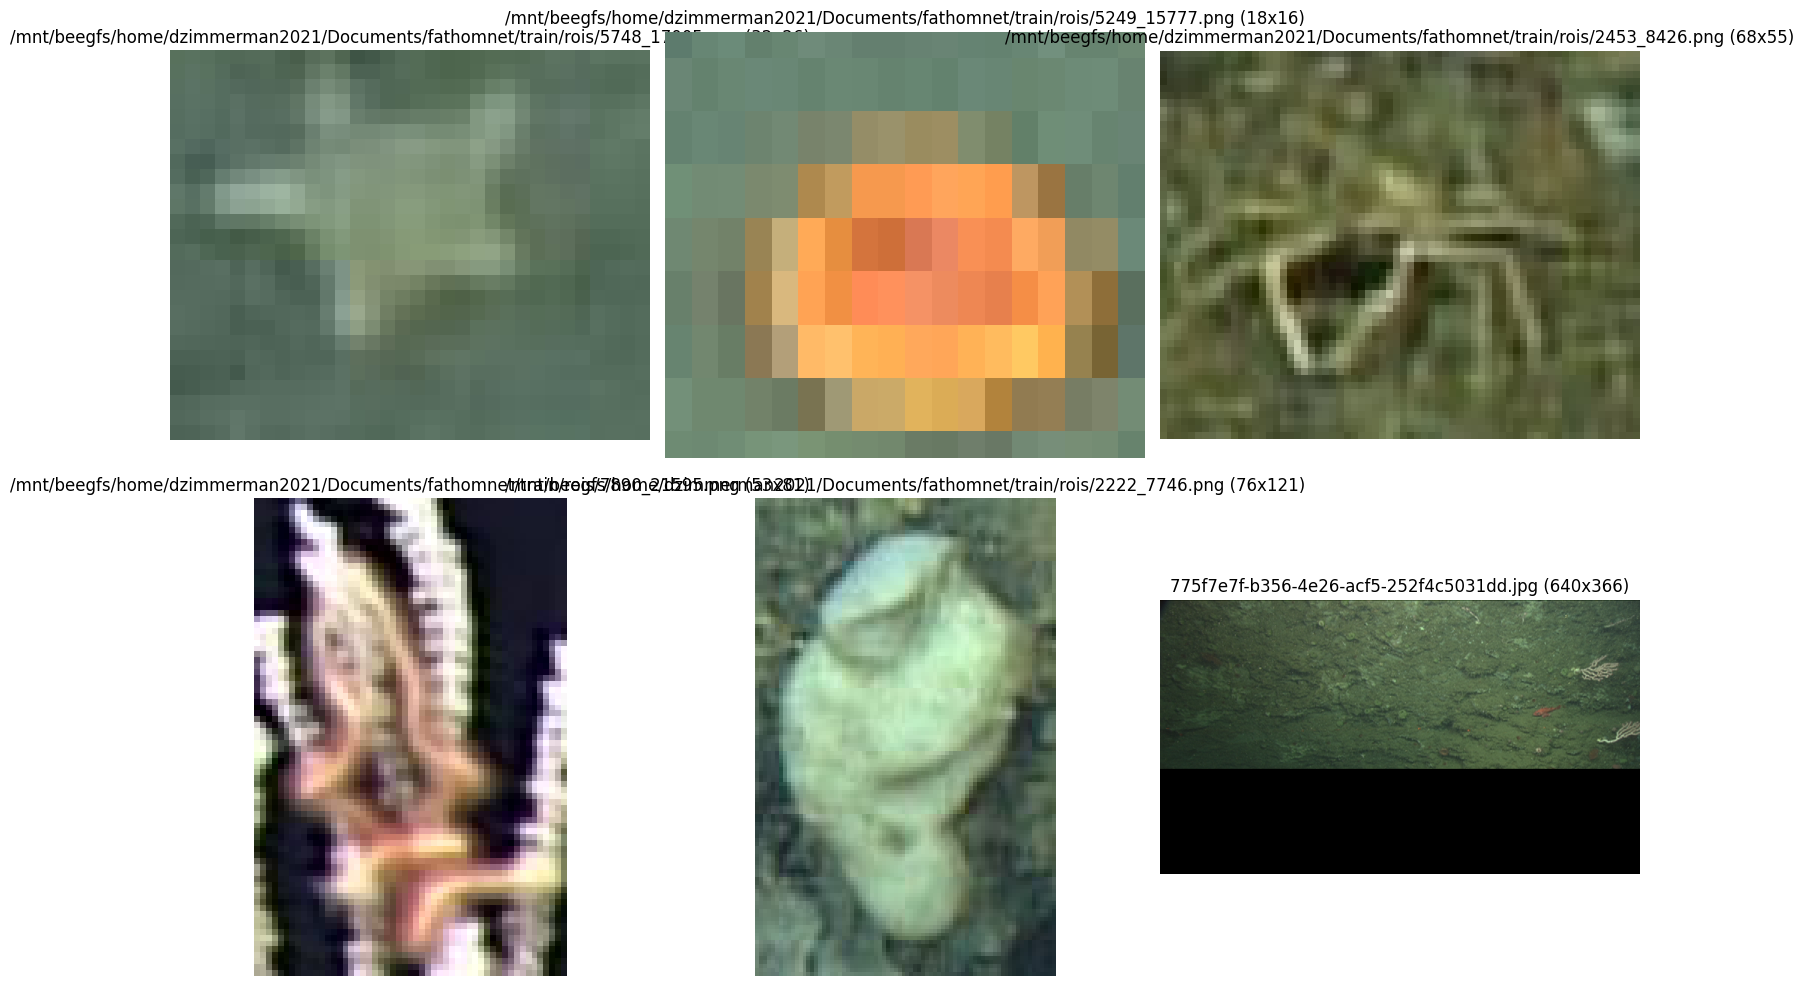


Analyzing image dimensions...


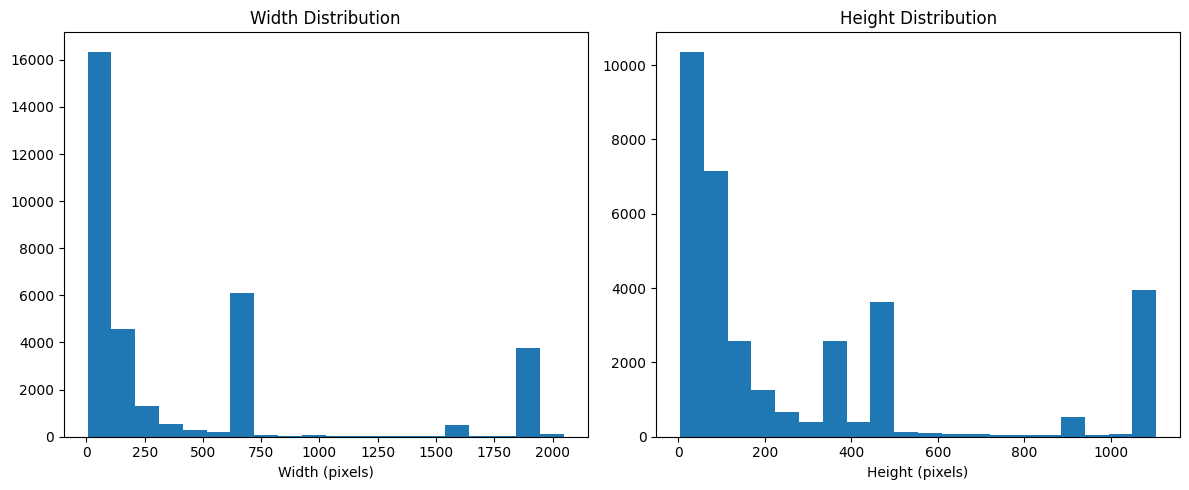

Median width: 116.0, Median height: 108.0
229 image(s) missing width or height

PREPARING TRAINING DATA
Preparing datasets...
Train: 29199 images
Val: 5153 images


In [31]:
print(f"RUN_EXPLORATION = {RUN_EXPLORATION}")

# Run data exploration
if RUN_EXPLORATION:
    print("Starting exploratory data analysis...")
    train_annotations = explore_dataset()
else:
    print("Skipping data exploration...")

# Always prepare training data (needed for taxonomy info)
print("\n" + "="*50)
print("PREPARING TRAINING DATA")
print("="*50)
train_loader, val_loader, taxonomy_df, encoders, class_counts, id_to_name, name_to_id = prepare_data()

In [32]:
if RUN_TRAINING:
    # Train the model (this will take time!)
    print("\n" + "="*50)
    print("STARTING MODEL TRAINING")
    print("="*50 + "\n")
    best_model_path = train_model(train_loader, val_loader, class_counts)
    print(f"Best model saved at: {best_model_path}")
elif LOAD_PRETRAINED:
    # Load a pretrained model
    print("\n" + "="*50)
    print(f"LOADING PRETRAINED MODEL: {PRETRAINED_PATH}")
    print("="*50 + "\n")
    best_model_path = PRETRAINED_PATH
    
    # Verify the model exists
    if not os.path.exists(best_model_path):
        print(f"ERROR: Pretrained model not found at {best_model_path}")
        # Create a placeholder to avoid errors in later cells
        best_model_path = None
else:
    print("Skipping model training and not loading pretrained model...")
    # Skip both training and loading pretrained
    best_model_path = None


STARTING MODEL TRAINING

Starting model training...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name              | Type             | Params | Mode 
----------------------------------------------------------------
0  | feature_extractor | Sequential       | 87.6 M | train
1  | shared_features   | Sequential       | 1.1 M  | train
2  | order_head        | Linear           | 43.1 K | train
3  | order_to_family   | Linear           | 22.0 K | train
4  | family_features   | Linear           | 524 K  | train
5  | family_head       | Linear           | 66.6 K | train
6  | family_to_genus   | Linear           | 33.8 K | train
7  | genus_features    | Linear           | 524 K  | train
8  | genus_head        | Linear           | 75.9 K | train
9  | genus_to_species  | Linear           | 38.4 K | train
10 | species_features  | Linear           | 524 K  | train
11 | speci

Error loading image /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images/1b5a013d-7646-491d-b270-0e699690eff6.jpg: cannot identify image file '/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images/1b5a013d-7646-491d-b270-0e699690eff6.jpg'
Epoch 0:   0%|          | 0/913 [00:00<?, ?it/s] Error loading image /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images/e9c71ef3-6852-44cc-9d18-65ea60dda2c6.jpg: cannot identify image file '/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images/e9c71ef3-6852-44cc-9d18-65ea60dda2c6.jpg'
Error loading image /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images/e102f95c-f78c-49f2-89df-9bfac259b425.jpg: cannot identify image file '/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images/e102f95c-f78c-49f2-89df-9bfac259b425.jpg'Error loading image /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/augment_dataset/images/270d6815-9c


Detected KeyboardInterrupt, attempting graceful shutdown ...
Exception in thread Thread-9 (_pin_memory_loop):
Traceback (most recent call last):
  File "/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CH

NameError: name 'exit' is not defined

In [ ]:
# Generate submission if we have a model
if GENERATE_SUBMISSION and best_model_path is not None:
    print("\n" + "="*50)
    print("PREPARING TEST DATA")
    print("="*50)
    test_loader = prepare_test_data(taxonomy_df)

    # Generate submission
    print("\n" + "="*50)
    print("GENERATING SUBMISSION")          
    print("="*50)
    
    submission_df = generate_submission(
        model_path=best_model_path,
        test_loader=test_loader,
        class_counts=class_counts,
        id_to_name=id_to_name,
        taxonomy_df=taxonomy_df
    )
    
    print(f"\nSubmission saved to: {Config.SUBMISSION_PATH}")
    print(f"Top submission classes:")
    print(submission_df['concept_name'].value_counts().head(10))
else:
    if best_model_path is None:
        print("Skipping submission generation: No model available")
    else:
        print("Skipping submission generation...")


PREPARING TEST DATA
Preparing test dataset...
Using row indices (0 to 787) as annotation IDs
Test dataset: 788 images

GENERATING SUBMISSION
Generating submission file...


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import os
import subprocess
import shutil

os.environ['KAGGLE_USERNAME'] = "****************"
os.environ['KAGGLE_KEY'] = "****************"

kaggle_path = shutil.which("kaggle")

result = subprocess.run([
    kaggle_path, "competitions", "submit", 
    "-c", "fathomnet-2025", 
    "-f", "submission.csv", 
    "-m", "Auto-submission"
], capture_output=True, text=True)

print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

if result.returncode != 0:
    print("Submission failed.")
else:
    print("Submission succeeded.")


STDOUT:
 Successfully submitted to FathomNet 2025 @ CVPR-FGVC
STDERR:
 
  0%|          | 0.00/14.5k [00:00<?, ?B/s]
100%|██████████| 14.5k/14.5k [00:00<00:00, 58.0kB/s]

Submission succeeded.


In [ ]:
import pandas as pd

df = pd.read_csv("submission.csv")

# Basic structure checks
assert list(df.columns) == ["annotation_id", "concept_name"], "Wrong column headers"
assert df["annotation_id"].is_unique, "Duplicate annotation_id"
assert df["annotation_id"].min() == 1, "IDs must start at 1"
assert df["annotation_id"].max() == len(df), "IDs must be consecutive"
assert df["concept_name"].notna().all(), "Found NaN in concept_name"
assert df["concept_name"].apply(lambda x: isinstance(x, str) and x.strip() != "").all(), "Empty or non-string values in concept_name"

print("Submission.csv passed all checks.")


Submission.csv passed all checks.


In [ ]:
# Load taxonomy
taxonomy_df = pd.read_csv("taxonomy.csv")
valid_species = set(taxonomy_df["species"].dropna().astype(str).str.strip())

# Load submission
submission_df = pd.read_csv("submission.csv")

# Check for invalid species names
invalid_names = submission_df[
    ~submission_df["concept_name"].isin(valid_species)
]

print(f"Found {len(invalid_names)} invalid concept names:")
print(invalid_names.head())


Found 0 invalid concept names:
Empty DataFrame
Columns: [annotation_id, concept_name]
Index: []
